In [1]:
import twint
import pandas as pd
import nest_asyncio
nest_asyncio.apply()
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import nltk
from wordcloud import WordCloud
import numpy as np
from PIL import Image
from textblob import TextBlob
import stanza
import statsmodels.api as sm
from statsmodels.api import OLS
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import scipy.stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import string

In [ ]:
# fix Twint package issues, if any

!pip3 uninstall twint --yes
!pip3 install --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

# Source

https://towardsdatascience.com/analyzing-tweets-with-nlp-in-minutes-with-spark-optimus-and-twint-a0c96084995f

In [2]:
# choose stock symbol and keyword to search

symbol = 'GME'
keyword = '$' + symbol

# determine the date range of tweets to scrape

date_list = pd.date_range(start = '2021-01-21', end = '2021-05-29')
length = len(date_list)
print('Number of date:', length)

# define the function to scrape Twitter

def scrape_tweets(keyword, start_date, end_date):    
    c = twint.Config()
    # limit of no of tweets of this search
    c.Limit = 1000
    c.Lang = "en"
    c.Search = keyword 
    c.Since = start_date
    c.Until = end_date
    c.Store_csv = True
    c.Pandas = True
    c.Output = "./tweets.csv"
    c.Hide_output = True
    c.Count = True

    twint.run.Search(c)

Number of date: 129


In [ ]:
%%time

# scrape the tweets

for i in range(length - 1):
    scrape_tweets(keyword, str(date_list[i]), str(date_list[i + 1]))

In [6]:
# read dataframe
df = pd.read_csv('tweets.csv')
data = df.copy()

# drop unnecessary columns
col = ['id', 'date', 'username', 'tweet', 'mentions', 'replies_count', 'retweets_count', 
      'likes_count', 'hashtags', 'cashtags', 'reply_to']
data = data[data['retweet'] == False][col]

# change the date column to datetime data type
data['date'] = data['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
data = data.sort_values('date').reset_index(drop = True)
print(data.shape)
data.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(130105, 11)


,id,date,username,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,cashtags,reply_to
0,1352325015862177792,2021-01-21,disrupttech2,$GME like I said earlier short trap covering g...,[],0,0,1,[],['gme'],[]
1,1352329503205371906,2021-01-21,therealjoeyb3,"$GME, I am taking my earnings! I can't do this...",[],1,0,0,[],['gme'],[]
2,1352329424234921984,2021-01-21,dmiko789,So @CitronResearch basically lied on YouTube t...,"[{'screen_name': 'citronresearch', 'name': 'ci...",2,9,47,[],['gme'],[]
3,1352329353179361280,2021-01-21,disrupttech2,$GME bears you thought that was it..,[],0,0,2,[],['gme'],[]
4,1352329263689547776,2021-01-21,mwmillion,@JasonRaznick You better find your balls and b...,"[{'screen_name': 'lukejacobi', 'name': 'hot st...",0,0,2,[],['gme'],[]


In [7]:
# define function to get the string format of date

def get_date(date): return str(date)[:10]

In [47]:
# get the data of stock

symbol_data = yf.Ticker(symbol).history(period = '1d', start = get_date(date_list[0]), 
                                 end = get_date(date_list[-1]))
symbol_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-20,37.369999,41.189999,36.060001,39.119999,33471800,0,0
2021-01-21,39.230000,44.750000,37.000000,43.029999,56216900,0,0
2021-01-22,42.590000,76.760002,42.320000,65.010002,197157900,0,0
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000,0,0
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000,0,0


In [10]:
# count the no of user interaction by date

data_interactions = data.groupby('date').sum().drop('id', axis = 1)
data_interactions.head()

,replies_count,retweets_count,likes_count
date,,,
2021-01-21,1054.0,467.0,7054.0
2021-01-22,789.0,582.0,7191.0
2021-01-23,1572.0,946.0,12282.0
2021-01-24,1102.0,703.0,7796.0
2021-01-25,629.0,421.0,4255.0


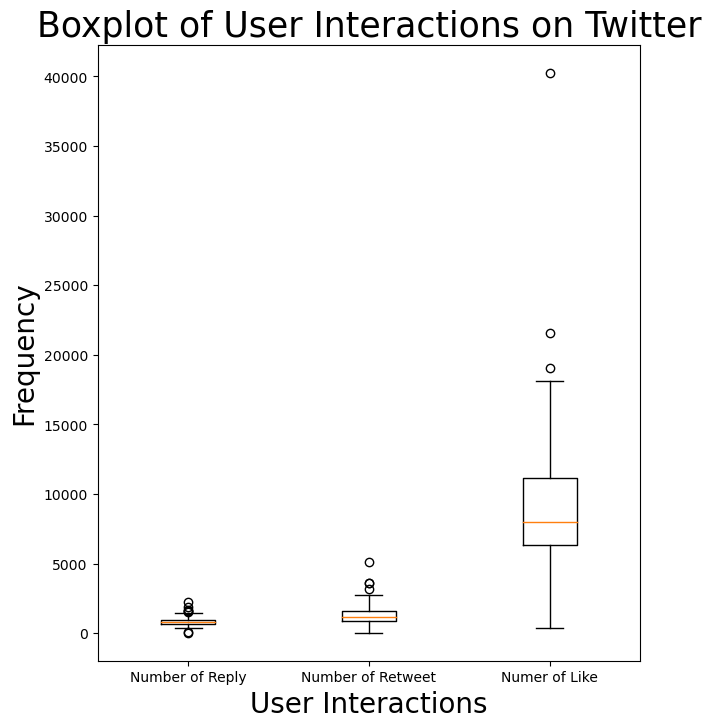

In [11]:
# plot the boxplot of user interactions on Twitter

labels = ['Number of Reply', 'Number of Retweet', 'Numer of Like']
fig, ax = plt.subplots(figsize = (7, 8))
plt.boxplot(data_interactions)
plt.xlabel('User Interactions', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Boxplot of User Interactions on Twitter', fontsize = 25)
ax.set_xticklabels(labels)
plt.show()

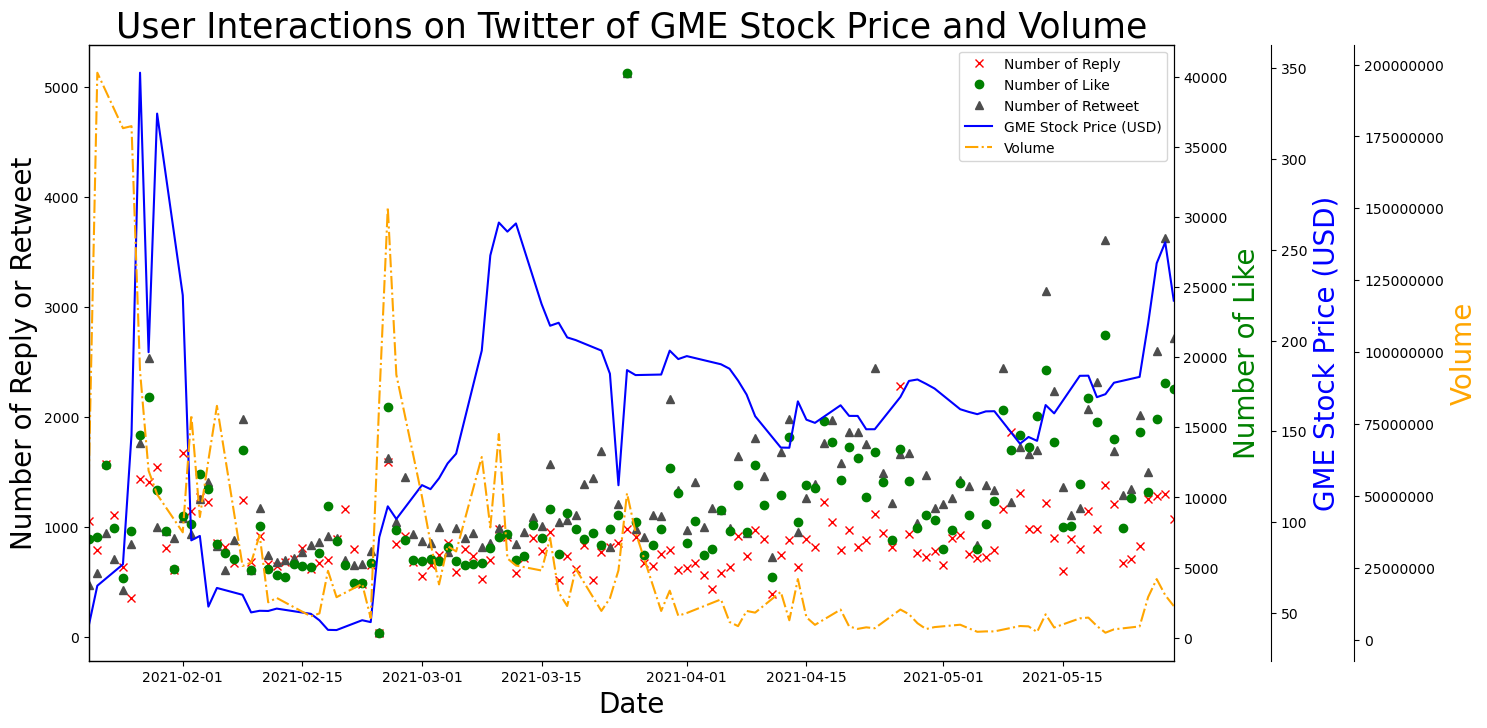

In [16]:
# plot user interactions on Twitter of GME stock price and volume

plot_title = 'User Interactions on Twitter of ' + symbol + ' Stock Price and Volume'
stock_label = symbol + ' Stock Price (USD)'

# more versatile wrapper
fig, host = plt.subplots(figsize = (14, 8)) 
host.set_title(plot_title, fontsize = 25)

# additional axis
par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

# set x limit
host.set_xlim(start_time, symbol_data.index[-1])
# don't display scientic notation
plt.ticklabel_format(style = 'plain', useOffset = False, axis = 'y')
    
host.set_xlabel("Date", fontsize = 20)
host.set_ylabel("Number of Reply or Retweet", fontsize = 20)
par2.set_ylabel(stock_label, fontsize = 20)
par3.set_ylabel("Volume", fontsize = 20)
par1.set_ylabel("Number of Like", fontsize = 20)

p1, = host.plot(data_interactions['replies_count'], 'x', color = 'red', label = "Number of Reply")
p2, = par1.plot(data_interactions['likes_count'], 'o', color = 'green', label = "Number of Like")
p3, = host.plot(data_interactions['retweets_count'], '^', color = '0.3', label = "Number of Retweet")
p4, = par2.plot(symbol_data['Close'], color = 'blue', label = stock_label)
p5, = par3.plot(symbol_data['Volume'], '-.', color = 'orange', label = "Volume")

lns = [p1, p2, p3, p4, p5]
# display legend and set its location
host.legend(handles = lns, loc = 'best')

# set the position of additional axis
par2.spines['right'].set_position(('outward', 70))
par3.spines['right'].set_position(('outward', 130))

# set the colour of axis label
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p4.get_color())
par3.yaxis.label.set_color(p5.get_color())

plt.show()

In [17]:
# get tweet data columns 

tweet_text = data.tweet

In [18]:
# call stop word list
stop_list = nltk.corpus.stopwords.words("english")

# extra stopwords
extra_stopwords = ["#ff", 'amp', "ff", "rt"]
stop_list.extend(extra_stopwords)

# set NLP pipeline parameters
nlp = stanza.Pipeline('en', processors = 'tokenize, lemma') 

2021-10-31 14:30:15 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2021-10-31 14:30:15 INFO: Use device: cpu
2021-10-31 14:30:15 INFO: Loading: tokenize
2021-10-31 14:30:15 INFO: Loading: lemma
2021-10-31 14:30:16 INFO: Done loading processors!


### github

https://github.com/NakulLakhotia/Hate-Speech-Detection-in-Social-Media-using-Python/blob/master/final_customization.ipynb

In [25]:
# define function to clean text data

def preprocess(text):  
    
    # removal of extra spaces
    text = re.sub(r'\s+', ' ', text)

    # removal of @name[mention]
    text = re.sub(r'@[\w\-]+', '', text)

    # removal of links[https://abc.com]
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # removal of punctuations and numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) \
               .translate(str.maketrans('', '', string.digits))
    
    # removal of stopwords    
    text = ' '.join([item for item in text.lower().split() if item not in stop_list])
    
    # lemmatization
    nlp_text = nlp(text)
    processed_text = ' '.join([' '.join([word.lemma for word in sentence.words]) for sentence in nlp_text.sentences])
      
    return processed_text

In [ ]:
%%time

# call function to clean tweets

processed_text = tweet_text.apply(lambda x: preprocess(x))

# export to csv
data.to_csv("processed_tweet.csv")

In [19]:
# display results after data cleaning

data['processed_text'] = processed_text
display(data[['tweet', 'processed_text']].head(10))

,tweet,processed_text
0,$GME like I said earlier short trap covering g...,gme like say early short trap cover go blood bath
1,"$GME, I am taking my earnings! I can't do this...",gme take earnings volitility big though share
2,So @CitronResearch basically lied on YouTube t...,basically lie youtube gamestop billion debt gm...
3,$GME bears you thought that was it..,gme bear think
4,@JasonRaznick You better find your balls and b...,good find ball buy gme like
5,@aggus970 Utter garbage. Shitron is full of sh...,utter garbage shitron full shit prove today gme
6,$GME Bear Hunting season starting soon..,gme bear hunt season start soon
7,@FuturamaKing @PBRStreetGang7 @ChrisDungeon In...,instead short gme deposit money bank account t...
8,$GME who sold 😂😂😂 have been saying this since ...,gme sell say since idiot
9,@RodAlzmann @Long_GME everything we heard in B...,everything hear benzinga stream today sound bu...


In [ ]:
# read dataframe

data = pd.read_csv('processed_tweet.csv', lineterminator = '\n').drop(['Unnamed: 0'], axis = 1)

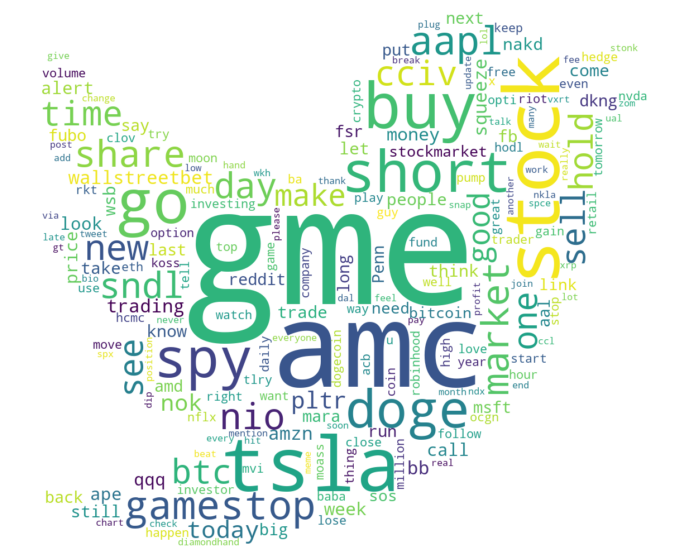

In [215]:
# plot word cloud of tweets

full_text = ' '.join([text for text in data['processed_text']])
# create a mask for the word cloud
mask = np.array(Image.open('twitter_logo.png'))
wordcloud = WordCloud(width = 500, height = 500, background_color = 'white', collocations = False, \
                       mask = mask).generate(full_text)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

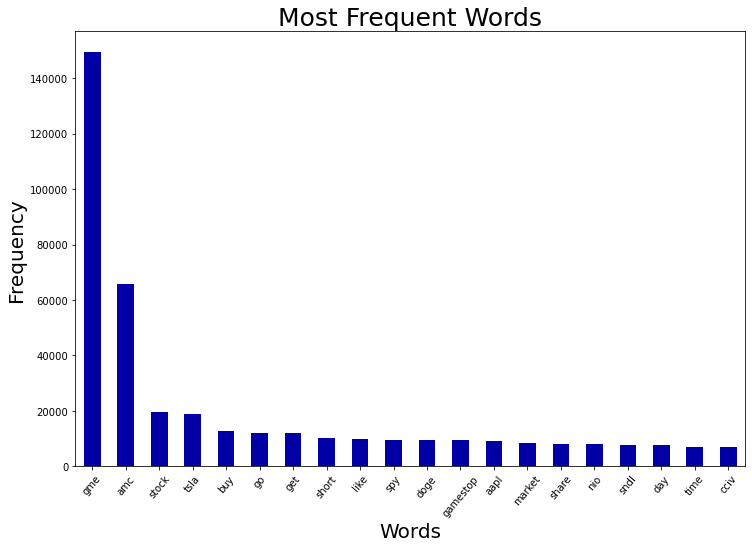

In [94]:
# plot most frequent words 

freq = pd.Series(' '.join(data['processed_text']).split()).value_counts()[:20]
plt.figure(figsize = (12, 8))
freq.plot.bar(color = '#0000A5')
plt.xticks(rotation = 50)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Most Frequent Words', fontsize = 25)
plt.show()

In [21]:
# define function to get tags

def get_tag(text):
    
    # removal of punctuations and numbers
    text = re.sub("[^a-zA-Z]", " ", text)
    # removal of extra spaces
    text = re.sub(r'\s+', ' ', text)
    # remove leading and trailing whitespace
    text = re.sub(r'^\s+|\s+?$', '', text)

    return text

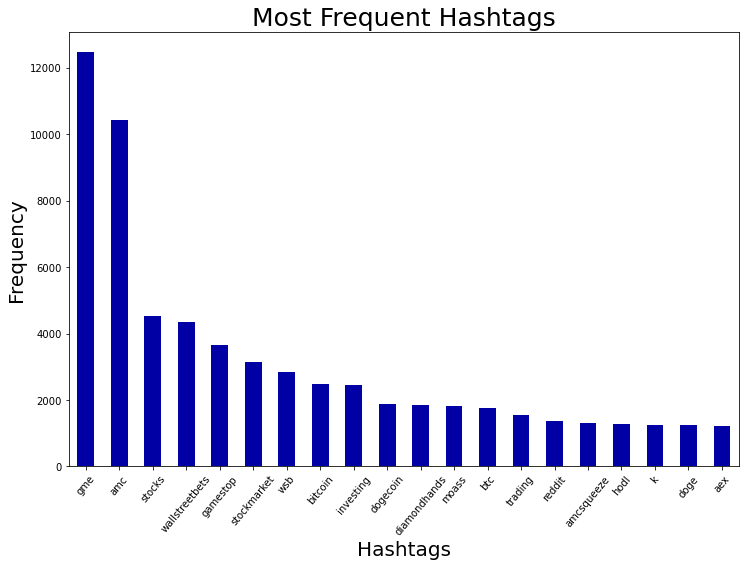

In [93]:
# call function to get hashtags

freq_hashtags = data['hashtags'].apply(get_tag)
# count most frequent hashtags
freq_hashtags = pd.Series(' '.join(freq_hashtags).split()).value_counts()[:20]

# plot most frequent hashtags
plt.figure(figsize = (12, 8))
freq_hashtags.plot.bar(color = '#0000A5')
plt.xticks(rotation = 50)
plt.xlabel('Hashtags', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Most Frequent Hashtags', fontsize = 25)
plt.show()

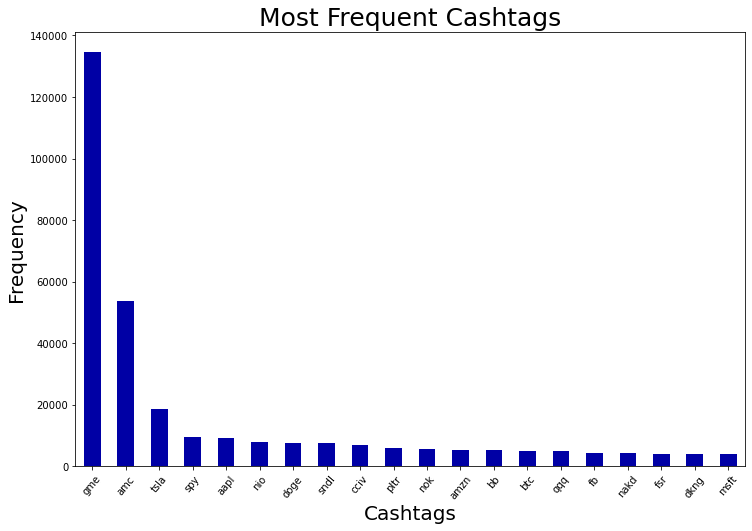

In [95]:
# call function to get cashtags

freq_cashtags = data['cashtags'].apply(get_tag)
# count most frequent cashtags
freq_cashtags = pd.Series(' '.join(freq_cashtags).split()).value_counts()[:20]

# plot most frequent hashtags
plt.figure(figsize = (12, 8))
freq_cashtags.plot.bar(color = '#0000A5')
plt.xticks(rotation = 50)
plt.xlabel('Cashtags', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Most Frequent Cashtags', fontsize = 25)
plt.show()

In [22]:
# define function to get mentions

def get_mention(mention):

    # return None when the cell is an empty list
    if mention == '[]':
        return None
    
    else:
        mention = mention.split(",")
        # get the names of mention
        mention = [name for name in mention if name.startswith(" 'name'")]
        mention = pd.DataFrame(mention)
        
        # get only the essential parts of string and put them into a list
        mention = mention[0].apply(lambda x: x[10:-1])
        mention = [tag for tag in mention]

        return mention

In [23]:
# define function to count user interactions

def count_interactions(inter_list):
    
    # exclude items with None
    inter_list = [item for item in inter_list if item != None]
    
    list_count = []
    for i in range(len(inter_list)):
        list_count += inter_list[i]
        
    list_count = pd.Series(list_count).value_counts()[:20]
        
    return list_count

In [26]:
# call function to get most frequent mentions

mention_list = data['mentions'].apply(get_mention)
mention_count = count_interactions(mention_list)
mention_count

roaring kitty               1035
sec enforcement              946
wallstreetbets               933
elon musk                    923
gamestop                     822
ryan cohen                   779
robinhood                    676
youtube                      611
jim cramer                   521
sec enforcement director     501
sec_news                     408
trey’s trades                407
investorplace                404
dave portnoy                 393
cnbc                         368
the chairman                 348
sec new york                 339
reddit                       294
bet99                        273
chamath palihapitiya         269
dtype: int64

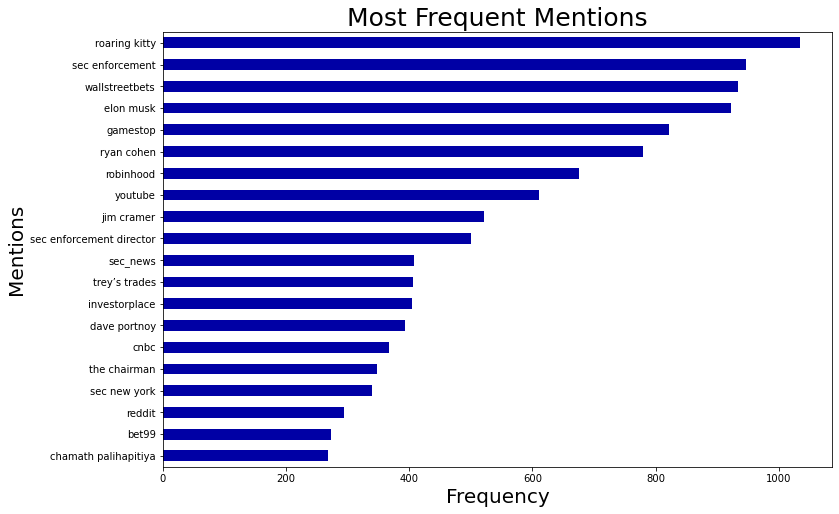

In [116]:
# plot most frequent mentions

plt.figure(figsize = (12, 8))
mention_count.plot.barh(mention_count, color = '#0000A5').invert_yaxis()
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Mentions', fontsize = 20)
plt.title('Most Frequent Mentions', fontsize = 25)
plt.show()

In [24]:
# call function to get users which have the most number of tweets reply them

reply_list = data['reply_to'].apply(get_mention)
reply_count = count_interactions(reply_list)
reply_count

Jim Cramer              1409
Roaring Kitty            981
Elon Musk                847
Tony Stonk™ 🍥            443
Dave Portnoy             436
GameStop                 417
Ryan Cohen               388
zerohedge                268
Gary Black               266
Josh                     264
Trey’s Trades            262
Robinhood                257
Citron Research          225
CNBC                     224
Cash App                 219
Chamath Palihapitiya     213
Dejv Zejn                198
The Chairman             195
Miley Ray Cyrus          183
VLAD                     182
dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127845 missing from current font.
  font.set_text(s, 0, flags=flags)


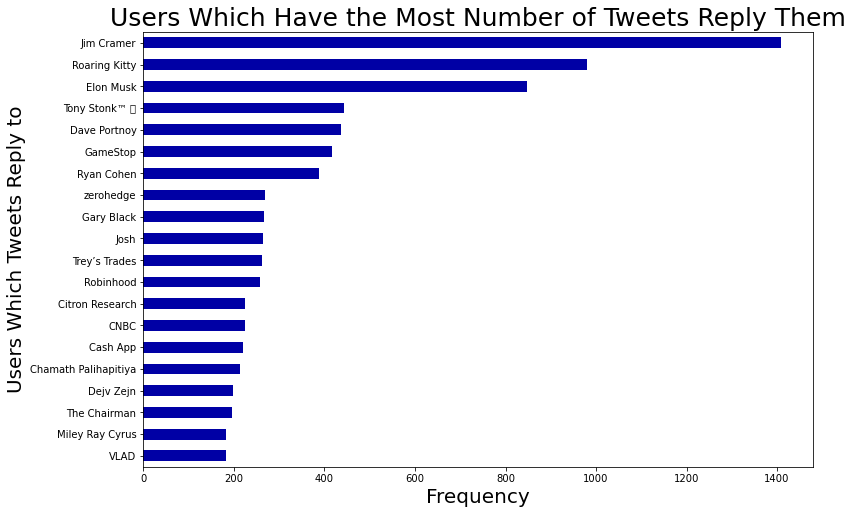

In [25]:
# plot users which have the most number of tweets reply them

plt.figure(figsize = (12, 8))
reply_count.plot.barh(reply_count, color = '#0000A5').invert_yaxis()
plt.xlabel('Frequency', fontsize = 20)
plt.ylabel('Users Which Tweets Reply to', fontsize = 20)
plt.title('Users Which Have the Most Number of Tweets Reply Them', fontsize = 25)
plt.show()

In [8]:
text_list = []

# get processed tweets by date 

for i in range(len(symbol_data)):
    text_by_date = data[data['date'] == get_date(date_list[i])]['processed_text']
    text_by_date = ' '.join([text for text in text_by_date])
    text_list.append(text_by_date)
      
sentiment_by_date = pd.DataFrame(text_list)
sentiment_by_date.columns = ['text']

# calculate the sentiment of the processed tweets

sentiment_by_date['sentiment'] = sentiment_by_date['text'].apply(lambda x: TextBlob(x).sentiment[0])
sentiment_by_date = sentiment_by_date.set_index(symbol_data.index)
sentiment_by_date

,text,sentiment
Date,,
2021-01-20,gme like say early short trap cover go blood b...,0.069185
2021-01-21,look gme graph please change name gamestock al...,0.079434
2021-01-22,fireside chat with episode jj explain exactly ...,0.078436
2021-01-25,hear yolo gme amc bby kid gme make easy buy st...,0.085763
2021-01-26,cero confianza en gme est interesante esa estr...,0.084402
...,...,...
2021-05-24,practice trading fake money see trading withou...,0.089291
2021-05-25,wonder gme clov gme amc pltr buy dip like sos ...,0.105812
2021-05-26,gme amc gme monthly update hold gme part sit i...,0.122413


In [222]:
# overall tweet sentiment

overall_sentiment = TextBlob(full_text).sentiment[0]
print("The overall sentiment of all tweets is: " + str(overall_sentiment), "1: positive", "-1: negative", sep = "\n")

The overall sentiment of all tweets is: 0.0931781293258777
1: positive
-1: negative


In [9]:
# get implied volatility data

iv = pd.read_csv('gme_iv.csv')
# set date to datetime data type
iv['date'] = iv['date'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y'))
iv = iv.set_index('date')
iv

,iv30
date,
2021-01-21,171.3
2021-01-22,249.0
2021-01-25,346.3
2021-01-26,385.4
2021-01-27,400.0
...,...
2021-05-24,121.4
2021-05-25,150.0
2021-05-26,166.2


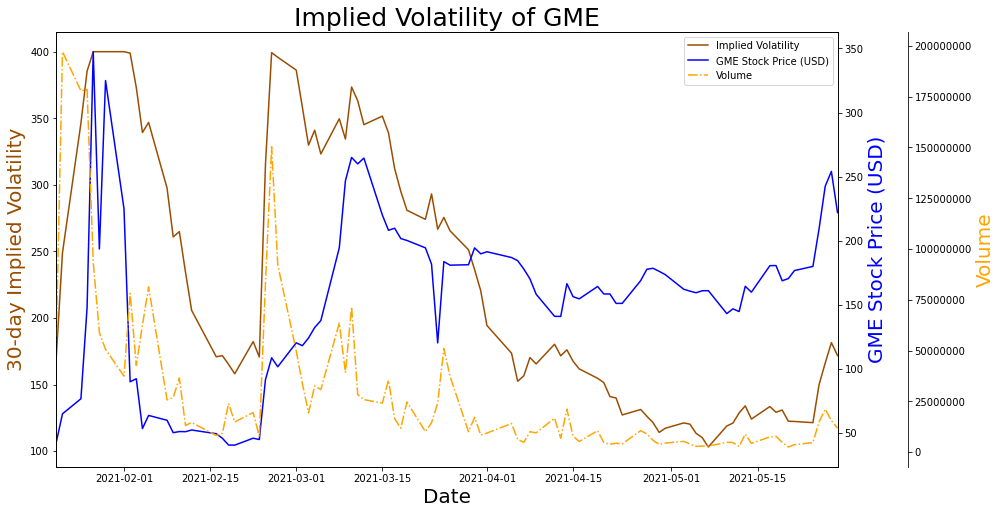

In [74]:
# plot implied volatility of GME

plot_title = 'Implied Volatility of ' + symbol
stock_label = symbol + ' Stock Price (USD)'

# more versatile wrapper
fig, host = plt.subplots(figsize = (14, 8)) 
host.set_title(plot_title, fontsize = 25)

# additional axis
par2 = host.twinx()
par3 = host.twinx()
    
# set x limit
host.set_xlim(start_time, symbol_data.index[-1])
# don't display scientific notation
plt.ticklabel_format(style = 'plain', useOffset = False, axis = 'y')
    
host.set_xlabel("Date", fontsize = 20)
host.set_ylabel("30-day Implied Volatility", fontsize = 20)
par2.set_ylabel(stock_label, fontsize = 20)
par3.set_ylabel("Volume", fontsize = 20)

p1, = host.plot(iv, color = '#994d00', label = "Implied Volatility")
p4, = par2.plot(symbol_data['Close'], color = 'blue', label = stock_label)
p5, = par3.plot(symbol_data['Volume'], '-.', color = 'orange', label = "Volume")

lns = [p1, p4, p5]
# display legend and set its location
host.legend(handles = lns, loc = 1)

# set position of additional axis
par3.spines['right'].set_position(('outward', 70))

# set colour of additional axis
host.yaxis.label.set_color(p1.get_color())
par2.yaxis.label.set_color(p4.get_color())
par3.yaxis.label.set_color(p5.get_color())

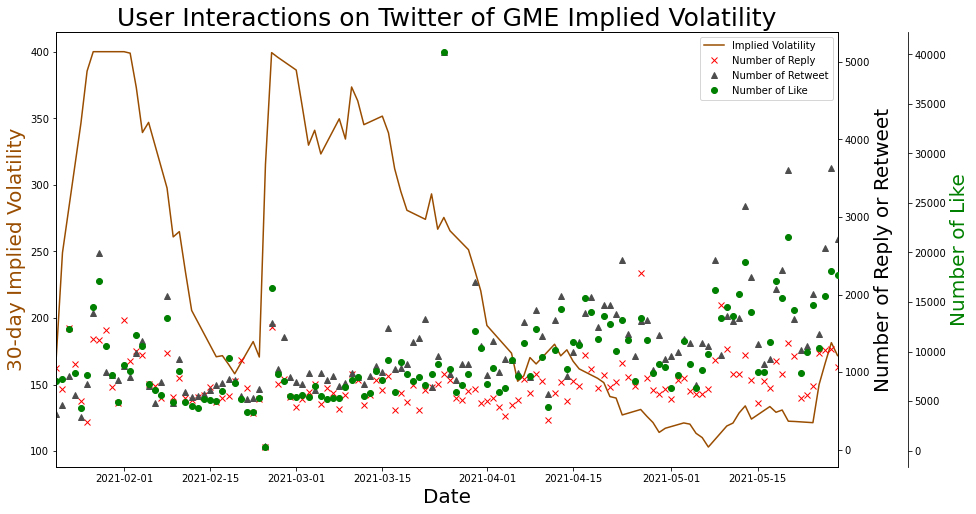

In [73]:
# plot user interactions on Twitter of GME implied volatility

plot_title = 'User Interactions on Twitter of ' + symbol + ' Implied Volatility'

# more versatile wrapper
fig, host = plt.subplots(figsize = (14, 8)) 
host.set_title(plot_title, fontsize = 25)

# additional axis
par1 = host.twinx()
par2 = host.twinx()
  
# set x limit
host.set_xlim(start_time, symbol_data.index[-1])
# don't display scientific notation
plt.ticklabel_format(style = 'plain', useOffset = False, axis = 'y')
    
host.set_xlabel("Date", fontsize = 20)
host.set_ylabel("30-day Implied Volatility", fontsize = 20)
par1.set_ylabel("Number of Reply or Retweet", fontsize = 20)
par2.set_ylabel("Number of Like", fontsize = 20)

p1, = host.plot(iv, color = '#994d00', label = "Implied Volatility")
p2, = par1.plot(data_interactions['replies_count'], 'x', color = 'red', label = "Number of Reply")
p3, = par1.plot(data_interactions['retweets_count'], '^', color = '0.3', label = "Number of Retweet")
p4, = par2.plot(data_interactions['likes_count'], 'o', color = 'green', label = "Number of Like")

lns = [p1, p2, p3, p4]
# display legend and set its location
host.legend(handles = lns, loc = 'best')

# set position of additional axis
par2.spines['right'].set_position(('outward', 70))

# set colour of additional axis
host.yaxis.label.set_color(p1.get_color())
par2.yaxis.label.set_color(p4.get_color())

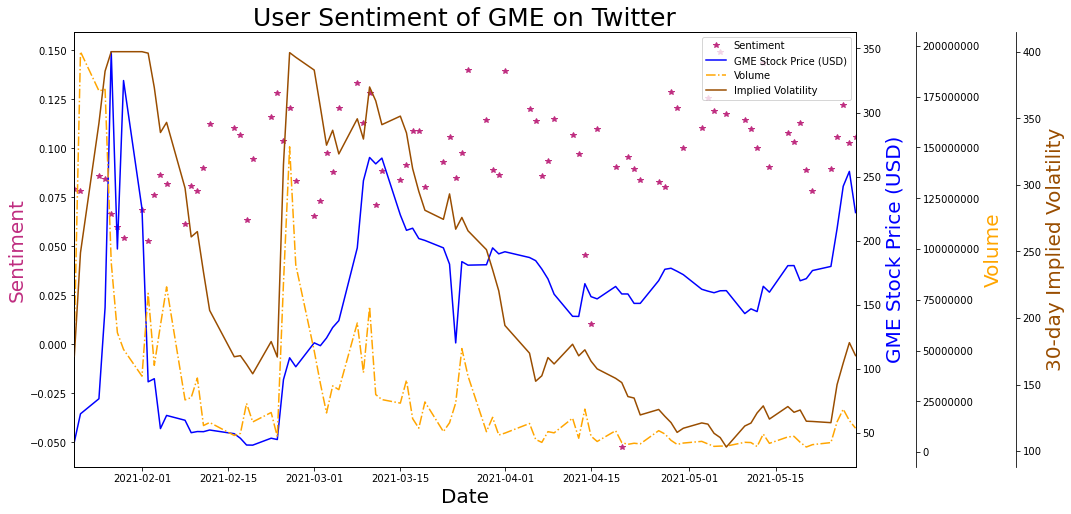

In [23]:
# plot user sentiment of GME on Twitter

plot_title = 'User Sentiment of ' + symbol + ' on Twitter'
stock_label = symbol + ' Stock Price (USD)'

# more versatile wrapper
fig, host = plt.subplots(figsize = (14, 8)) 
host.set_title(plot_title, fontsize = 25)

# additional axis
par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
    
# set x limit
host.set_xlim(start_time, symbol_data.index[-1])
par2.ticklabel_format(style = 'plain', useOffset = False, axis = 'y')
    
host.set_xlabel("Date", fontsize = 20)
host.set_ylabel("Sentiment", fontsize = 20)
par1.set_ylabel(stock_label, fontsize = 20)
par2.set_ylabel("Volume", fontsize = 20)
par3.set_ylabel("30-day Implied Volatility", fontsize = 20)

p1, = host.plot(sentiment_by_date['sentiment'], '*', color = '#bf2d80', label = "Sentiment")
p2, = par1.plot(symbol_data['Close'], color = 'blue', label = stock_label)
p3, = par2.plot(symbol_data['Volume'], '-.', color = 'orange', label = "Volume")
p4, = par3.plot(iv, color = '#994d00', label = "Implied Volatility")

lns = [p1, p2, p3, p4]
# display legend and set its location
host.legend(handles = lns, loc = 1)

# set position of additional axis
par2.spines['right'].set_position(('outward', 60))
par3.spines['right'].set_position(('outward', 160))

# set colour of additional axis
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
par3.yaxis.label.set_color(p4.get_color())

In [11]:
# combine data for modelling

# combine stock and iv data
model_data = symbol_data.merge(iv, left_index = True, right_index = True)
# combine with sentiment data
model_data = model_data.merge(sentiment_by_date, left_index = True, right_index = True)
# set index to datatime data type
data_interactions.index = pd.Series(data_interactions.index).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
# combine with user interaction data
model_data = model_data.merge(data_interactions, left_index = True, right_index = True)
# set index to datetime frequency to "day"
model_data.index = pd.DatetimeIndex(model_data.index).to_period('D')
model_data = model_data.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'text'], axis = 1)
# apply log calculation to each cell and drop nan values
model_data_log = np.log(model_data).dropna()
display(model_data_log)

,Close,Volume,iv30,sentiment,replies_count,retweets_count,likes_count
2021-01-21,3.761898,17.844728,5.143416,-2.532829,6.960348,6.146329,8.861350
2021-01-22,4.174541,19.099515,5.517453,-2.545471,6.670766,6.366470,8.880586
2021-01-25,4.341074,18.996586,5.847305,-2.456167,6.444131,6.042633,8.355850
2021-01-26,4.997077,19.000592,5.954282,-2.472166,5.866468,6.740519,8.935640
2021-01-27,5.850793,18.352367,5.991465,-2.711050,7.266129,7.475339,9.579003
...,...,...,...,...,...,...,...
2021-05-24,5.193012,15.355448,4.799091,-2.415852,6.711740,7.607878,9.592537
2021-05-25,5.344390,16.516032,5.010635,-2.246089,7.129298,7.309212,9.248310
2021-05-26,5.491249,16.865726,5.113192,-2.100353,7.155396,7.862497,9.652844
2021-05-27,5.537846,16.558046,5.201256,-2.273947,7.165493,8.195885,9.805930


In [15]:
# descriptive statistics

names = ['Log(Price)', 'Log(Volume)', 'Log(IV)', 'Log(Sentiment)', 'Log(Replies)', 'Log(Retweets)', 'Log(Likes)']
model_data_log.columns = names
dt = model_data_log.describe().transpose()
dt.columns = ['N', 'Mean', 'SD', 'Min', '1st Quartile', '2nd Quartile', '3rd Quartile', 'Max']
dt = dt.apply(lambda x: round(x, 3))
dt['N'] = dt['N'].apply(int)
dt

,N,Mean,SD,Min,1st Quartile,2nd Quartile,3rd Quartile,Max
Log(Price),89,4.927,0.527,3.704,4.790,5.089,5.231,5.851
Log(Volume),89,16.574,1.104,14.723,15.733,16.495,17.383,19.100
Log(IV),89,5.343,0.436,4.636,4.941,5.201,5.798,5.991
Log(Sentiment),89,-2.377,0.329,-4.543,-2.487,-2.347,-2.183,-1.901
Log(Replies),89,6.714,0.459,3.555,6.544,6.706,6.890,7.731
Log(Retweets),89,7.106,0.580,3.784,6.816,7.065,7.432,8.543
Log(Likes),89,9.095,0.542,5.875,8.835,9.076,9.419,10.603


In [76]:
# export to csv

dt.to_csv('dt_twitter.csv')

In [18]:
# Pearson correlation matrix

cor_dt = model_data_log.corr().apply(lambda x: round(x, 3))
cor_dt

,Log(Price),Log(Volume),Log(IV),Log(Sentiment),Log(Replies),Log(Retweets),Log(Likes)
Log(Price),1.000,-0.190,-0.018,0.061,0.190,0.403,0.356
Log(Volume),-0.190,1.000,0.856,-0.223,-0.120,-0.394,-0.293
Log(IV),-0.018,0.856,1.000,-0.238,-0.116,-0.332,-0.311
Log(Sentiment),0.061,-0.223,-0.238,1.000,-0.139,0.023,-0.070
Log(Replies),0.190,-0.120,-0.116,-0.139,1.000,0.740,0.815
Log(Retweets),0.403,-0.394,-0.332,0.023,0.740,1.000,0.940
Log(Likes),0.356,-0.293,-0.311,-0.070,0.815,0.940,1.000


In [82]:
# export csv

cor_dt.to_csv('cor_dt_twitter.csv')

In [19]:
# calculate p-values of Pearson correlation

cor_test = model_data_log.copy()
target = 'Log(Price)'
col = cor_test.loc[:, target]
cor_test = cor_test.drop(target, axis = 1)
display(col)
display(cor_test)
n = cor_test.columns

for i in range(len(n)):
    print(scipy.stats.pearsonr(col, cor_test[n[i]]))

2021-01-21    3.761898
2021-01-22    4.174541
2021-01-25    4.341074
2021-01-26    4.997077
2021-01-27    5.850793
                ...   
2021-05-24    5.193012
2021-05-25    5.344390
2021-05-26    5.491249
2021-05-27    5.537846
2021-05-28    5.402677
Freq: D, Name: Log(Price), Length: 89, dtype: float64

,Log(Volume),Log(IV),Log(Sentiment),Log(Replies),Log(Retweets),Log(Likes)
2021-01-21,17.844728,5.143416,-2.532829,6.960348,6.146329,8.861350
2021-01-22,19.099515,5.517453,-2.545471,6.670766,6.366470,8.880586
2021-01-25,18.996586,5.847305,-2.456167,6.444131,6.042633,8.355850
2021-01-26,19.000592,5.954282,-2.472166,5.866468,6.740519,8.935640
2021-01-27,18.352367,5.991465,-2.711050,7.266129,7.475339,9.579003
...,...,...,...,...,...,...
2021-05-24,15.355448,4.799091,-2.415852,6.711740,7.607878,9.592537
2021-05-25,16.516032,5.010635,-2.246089,7.129298,7.309212,9.248310
2021-05-26,16.865726,5.113192,-2.100353,7.155396,7.862497,9.652844
2021-05-27,16.558046,5.201256,-2.273947,7.165493,8.195885,9.805930


(-0.1904874695460985, 0.07376605535331046)
(-0.01810781474581666, 0.8662468650636052)
(0.06129118162715984, 0.5682825681580274)
(0.1904899102141705, 0.07376229040744074)
(0.4026187600550779, 9.17242964991033e-05)
(0.3563391121079926, 0.0006093656615754127)


In [21]:
# 1-way Anova

stats.f_oneway(model_data_log['Log(Sentiment)'], model_data_log['Log(Replies)'], model_data_log['Log(Retweets)'], \
              model_data_log['Log(Likes)'])

F_onewayResult(statistic=9813.075201692789, pvalue=0.0)

In [43]:
# OLS regression model of stock price

X = model_data_log.drop(['Log(Price)', 'Log(Volume)', 'Log(IV)'], axis = 1)
X = sm.add_constant(X)
y = model_data_log.loc[:, 'Log(Price)']

model_1 = sm.OLS(y, X).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Log(Price)   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     4.703
Date:                Fri, 09 Jul 2021   Prob (F-statistic):            0.00179
Time:                        00:08:15   Log-Likelihood:                -59.466
No. Observations:                  89   AIC:                             128.9
Df Residuals:                      84   BIC:                             141.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9127      1.232      2.364      0.018       0.497       5.328
Log(Sentiment)     0.0328      0.132      0.248      0.804      -0.227       0.292
Log(Replies)      -0.2890      0.237     -1.220      0.223      -0.753       0.175
Log(Retweets)      0.4632      0.270      1.715      0.086      -0.066       0.992
Log(Likes)         0.0815      0.346      0.235      0.814      -0.597       0.760
==============================================================================
Omnibus:                        3.946   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.466
Skew:                          -0.479   Prob(JB):                        0.177
Kurtosis:                       3.127   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [56]:
# OLS regression model of stock price without the number of likes

X_wo = model_data_log.drop(['Log(Price)', 'Log(Volume)', 'Log(IV)', 'Log(Likes)'], axis = 1)
X_wo = sm.add_constant(X_wo)
y = model_data_log.loc[:, 'Log(Price)']

model_1_wo = sm.OLS(y, X_wo).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_1_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Log(Price)   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.286
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           0.000665
Time:                        00:23:40   Log-Likelihood:                -59.498
No. Observations:                  89   AIC:                             127.0
Df Residuals:                      85   BIC:                             137.0
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.0665      0.901      3.404      0.001       1.301       4.832
Log(Sentiment)     0.0256      0.138      0.185      0.853      -0.245       0.297
Log(Replies)      -0.2654      0.207     -1.283      0.200      -0.671       0.140
Log(Retweets)      0.5212      0.154      3.393      0.001       0.220       0.822
==============================================================================
Omnibus:                        4.187   Durbin-Watson:                   0.539
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.684
Skew:                          -0.493   Prob(JB):                        0.158
Kurtosis:                       3.150   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [23]:
# OLS regression model of volume

y = model_data_log.loc[:, 'Log(Volume)']

model_2 = sm.OLS(y, X).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Log(Volume)   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     6.159
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           0.000214
Time:                        23:42:07   Log-Likelihood:                -121.65
No. Observations:                  89   AIC:                             253.3
Df Residuals:                      84   BIC:                             265.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.4367      2.395      7.281      0.000      12.743      22.131
Log(Sentiment)    -0.4979      0.525     -0.948      0.343      -1.527       0.531
Log(Replies)       0.5947      0.510      1.166      0.244      -0.405       1.594
Log(Retweets)     -1.6236      0.599     -2.709      0.007      -2.798      -0.449
Log(Likes)         0.6045      0.888      0.681      0.496      -1.136       2.345
==============================================================================
Omnibus:                        2.623   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.269   Jarque-Bera (JB):                2.612
Skew:                           0.396   Prob(JB):                        0.271
Kurtosis:                       2.725   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [58]:
# OLS regression model of volume without the number of likes

y = model_data_log.loc[:, 'Log(Volume)']

model_2_wo = sm.OLS(y, X_wo).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_2_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Log(Volume)   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     5.928
Date:                Fri, 09 Jul 2021   Prob (F-statistic):            0.00101
Time:                        00:24:01   Log-Likelihood:                -122.08
No. Observations:                  89   AIC:                             252.2
Df Residuals:                      85   BIC:                             262.1
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.5771      1.682     11.047      0.000      15.281      21.873
Log(Sentiment)    -0.5511      0.527     -1.046      0.295      -1.583       0.481
Log(Replies)       0.7697      0.385      2.000      0.045       0.016       1.524
Log(Retweets)     -1.1936      0.353     -3.384      0.001      -1.885      -0.502
==============================================================================
Omnibus:                        4.861   Durbin-Watson:                   0.747
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.415
Skew:                           0.542   Prob(JB):                        0.110
Kurtosis:                       3.132   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [24]:
# OLS regression model of implied volatility

y = model_data_log.loc[:, 'Log(IV)']

model_3 = sm.OLS(y, X).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Log(IV)   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.032
Date:                Thu, 08 Jul 2021   Prob (F-statistic):            0.00486
Time:                        23:42:47   Log-Likelihood:                -41.588
No. Observations:                  89   AIC:                             93.18
Df Residuals:                      84   BIC:                             105.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7391      1.040      6.480      0.000       4.701       8.778
Log(Sentiment)    -0.2970      0.234     -1.271      0.204      -0.755       0.161
Log(Replies)       0.3297      0.216      1.527      0.127      -0.093       0.753
Log(Retweets)     -0.0692      0.219     -0.316      0.752      -0.498       0.359
Log(Likes)        -0.4205      0.335     -1.257      0.209      -1.076       0.235
==============================================================================
Omnibus:                        6.926   Durbin-Watson:                   0.358
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                3.190
Skew:                           0.180   Prob(JB):                        0.203
Kurtosis:                       2.146   Cond. No.                         282.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [60]:
# OLS regression model of volume without the number of likes

y = model_data_log.loc[:, 'Log(IV)']

model_3_wo = sm.OLS(y, X_wo).fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
model_3_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Log(IV)   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     5.604
Date:                Fri, 09 Jul 2021   Prob (F-statistic):            0.00148
Time:                        00:24:17   Log-Likelihood:                -42.828
No. Observations:                  89   AIC:                             93.66
Df Residuals:                      85   BIC:                             103.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.9458      0.725      8.202      0.000       4.525       7.367
Log(Sentiment)    -0.2600      0.232     -1.122      0.262      -0.714       0.194
Log(Replies)       0.2080      0.167      1.245      0.213      -0.119       0.535
Log(Retweets)     -0.3683      0.129     -2.856      0.004      -0.621      -0.116
==============================================================================
Omnibus:                       27.012   Durbin-Watson:                   0.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.322
Skew:                           0.071   Prob(JB):                       0.0699
Kurtosis:                       1.810   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

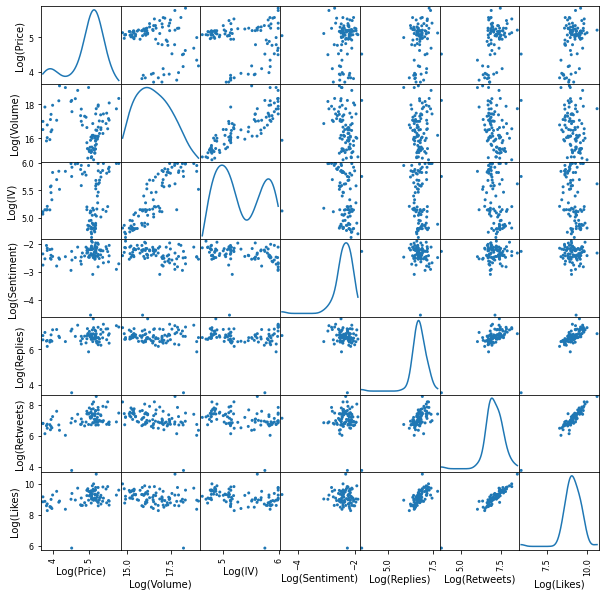

In [25]:
# scatter matrix of all variables

pd.plotting.scatter_matrix(model_data_log, diagonal = 'kde', figsize = (10, 10), alpha = 1)
plt.show()

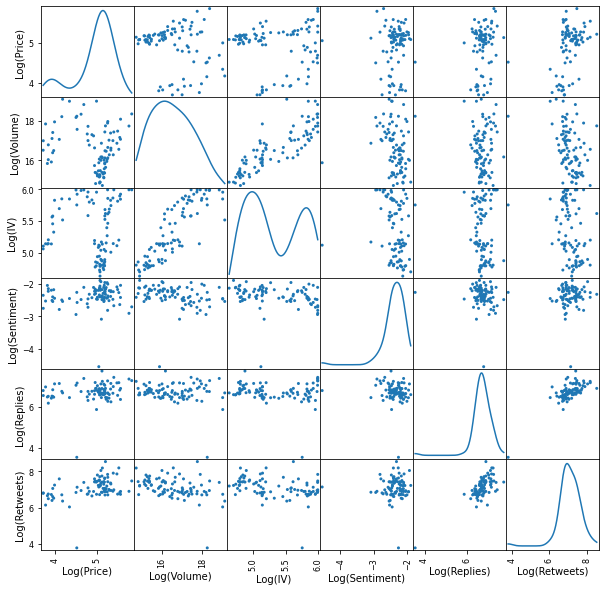

In [47]:
# scatter matrix of variables without Log(Likes)

temp = model_data_log.drop('Log(Likes)', axis = 1)
pd.plotting.scatter_matrix(temp, diagonal = 'kde', figsize = (10, 10), alpha = 1)
plt.show()

In [58]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(Price) with all independent variables

print('Mean:', sum(model_1.resid)/len(model_1.resid))
print(stats.shapiro(model_1.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_1.resid, model_1.model.exog)
lzip(name, test)

Mean: 8.522521015998954e-15
ShapiroResult(statistic=0.9527925848960876, pvalue=0.0026762220077216625)


[('Lagrange multiplier statistic', 17.058296940126446),
 ('p-value', 0.001883180626688646),
 ('f-value', 4.979368301088492),
 ('f p-value', 0.0011897548599400284)]

In [52]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(Price) without Log(Likes)

print('Mean:', sum(model_1_wo.resid)/len(model_1_wo.resid))
print(stats.shapiro(model_1_wo.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_1_wo.resid, model_1_wo.model.exog)
lzip(name, test)

Mean: -2.225435815653123e-15
ShapiroResult(statistic=0.9500055909156799, pvalue=0.0017987696919590235)


[('Lagrange multiplier statistic', 15.7253815974967),
 ('p-value', 0.001290870707652722),
 ('f-value', 6.080584086406083),
 ('f p-value', 0.0008455792580489103)]

In [59]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(Volume) with all independent variables

print('Mean:', sum(model_2.resid)/len(model_2.resid))
print(stats.shapiro(model_2.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_2.resid, model_2.model.exog)
lzip(name, test)

Mean: 3.704402577445916e-14
ShapiroResult(statistic=0.9787135720252991, pvalue=0.1516367495059967)


[('Lagrange multiplier statistic', 17.665026154951207),
 ('p-value', 0.001434672724794155),
 ('f-value', 5.200332028715299),
 ('f p-value', 0.0008600030549151035)]

In [53]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(Volume) without Log(Likes)

print('Mean:', sum(model_2_wo.resid)/len(model_2_wo.resid))
print(stats.shapiro(model_2_wo.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_2_wo.resid, model_2_wo.model.exog)
lzip(name, test)

Mean: -6.1274331426503025e-15
ShapiroResult(statistic=0.9742082953453064, pvalue=0.0731671079993248)


[('Lagrange multiplier statistic', 5.598809380976745),
 ('p-value', 0.13284672691331426),
 ('f-value', 1.902046377079235),
 ('f p-value', 0.13539018954545273)]

In [60]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(IV) with all independent variables

print('Mean:', sum(model_3.resid)/len(model_3.resid))
print(stats.shapiro(model_3.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_3.resid, model_3.model.exog)
lzip(name, test)

Mean: 8.43270522074838e-15
ShapiroResult(statistic=0.9684592485427856, pvalue=0.02897060289978981)


[('Lagrange multiplier statistic', 13.809684304244605),
 ('p-value', 0.00792790353417531),
 ('f-value', 3.856924494938752),
 ('f p-value', 0.006316265182705205)]

In [54]:
# mean calculation, Shapiro-Wilk test, and Breusch-Pagan test for the model of Log(IV) without Log(Likes)

print('Mean:', sum(model_3_wo.resid)/len(model_3_wo.resid))
print(stats.shapiro(model_3_wo.resid))

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model_3_wo.resid, model_3_wo.model.exog)
lzip(name, test)

Mean: -2.0358246923463543e-15
ShapiroResult(statistic=0.9567316770553589, pvalue=0.004757555201649666)


[('Lagrange multiplier statistic', 10.56551349079613),
 ('p-value', 0.01432300382262752),
 ('f-value', 3.816640216512786),
 ('f p-value', 0.01283499099201469)]

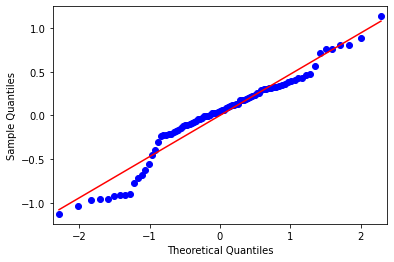

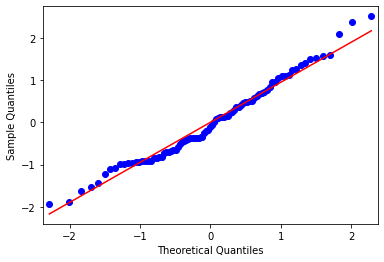

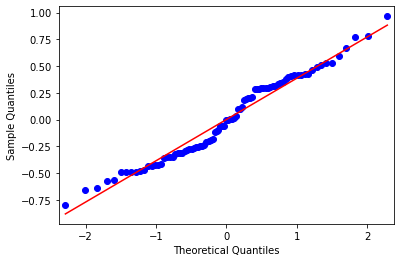

In [61]:
# q-q plots

sm.qqplot(model_1.resid, line = 's')
sm.qqplot(model_2.resid, line = 's')
sm.qqplot(model_3.resid, line = 's')
plt.show()

In [26]:
# vif calculations

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.index = X.columns
vif

,VIF
const,404.798675
Log(Sentiment),1.092064
Log(Replies),3.065935
Log(Retweets),9.345727
Log(Likes),12.211989


In [51]:
# vif calculations without Log(Likes)

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_wo.values, i) for i in range(X_wo.shape[1])]
vif.index = X_wo.columns
vif

,VIF
const,255.396717
Log(Sentiment),1.057199
Log(Replies),2.332513
Log(Retweets),2.288787
